In [ ]:
#Importar las librerias requeridas
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import color, io
import cv2 as cv

from google.colab import drive

# Acceso a Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

print (tf.__version__)
BATCH=32
EPOCH=20
IMG_SIZE=96
NUM_CLASSES=1
IMG_CHANNELS = 3
#colocar ruta del drive
TRAIN_PATH = "/content/drive/MyDrive/Colab/Breast cancer/Histopatologias/train/"
VALID_PATH = "/content/drive/MyDrive/Colab/Breast cancer/Histopatologias/valid/"

MODEL_PATH_ROOT="/content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/"
MODELTF_PATH= MODEL_PATH_ROOT+'model-InternalStructure-Unet-mobilenetv2-11Feb.h5'

2.15.0


In [ ]:
#Extraer la ruta de la carpeta de train (directorio)
local_train_path = os.path.dirname(TRAIN_PATH)

data_train = os.path.join(local_train_path, "")
print(data_train)

/content/drive/MyDrive/Colab/Breast cancer/Histopatologias/train/


In [ ]:
# Cargar imágenes desde el directorio de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  seed=123,
  #color_mode='grayscale',  # Descomentar si se necesitan imágenes en escala de grises
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH
)
# Mostrar cuántas clases hay en el dataset de entrenamiento
train_class_names = train_ds.class_names
print(f"El dataset de entrenamiento contiene las siguientes clases: {train_class_names}")

Found 7011 files belonging to 2 classes.
El dataset de entrenamiento contiene las siguientes clases: ['Benigno', 'Maligno']


In [ ]:
#Extraer la ruta de la carpeta de valid (directorio)
local_valid_path = os.path.dirname(VALID_PATH)

data_valid = os.path.join(local_valid_path, "")
print(data_valid)

/content/drive/MyDrive/Colab/Breast cancer/Histopatologias/valid/


In [ ]:
# Cargar imágenes desde el directorio de prueba
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_valid,
  seed=123,
  #color_mode='grayscale',  # Descomentar si se necesitan imágenes en escala de grises
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH
)
# Mostrar cuántas clases hay en el dataset de prueba
val_class_names = val_ds.class_names
print(f"El dataset de validacion contiene las siguientes clases: {val_class_names}")

Found 3001 files belonging to 2 classes.
El dataset de validacion contiene las siguientes clases: ['Benigno', 'Maligno']


In [ ]:
#Verificar las dimensiones de los datos
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
#Batch, 96x96 pixeles, canales de color RGB
#Etiquetas binarias

(32, 96, 96, 3)
(32,)


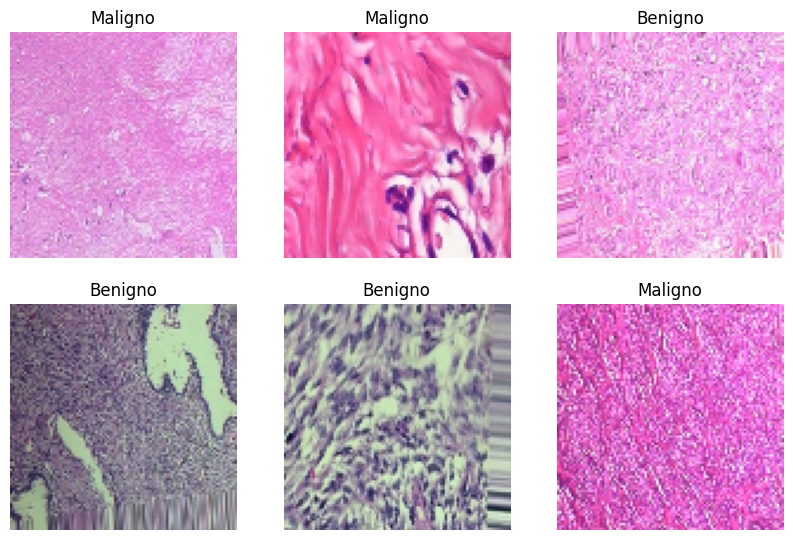

In [ ]:
import matplotlib.pyplot as plt
#Imagen de reconocimiento de fracturas
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
#Mejora el rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Inicio de entrenamiento

In [ ]:
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Resizing
from keras.layers import Concatenate


def build_model(num_classes):
    #Capa de entrada imagenes de este tamaño
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    #utiliza capas preentrenables
    model.trainable = True#False to freeze
    #Reduce la dimension de cada caracteristica
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    #Ayuda a estabiliza y acelerar el entrenamiento
    x = layers.BatchNormalization()(x)
    #Ayuda a prevenir el sobreajuste
    #De manera aleatoria se activan y desactivan las neuronas
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #Añade una capa densa
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    #Adam es el optimizador
    #Tasa de aprendizaje de 0.0001 para que el modelo aprenda poco a poco
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
         optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy']
    )
    return model
model=build_model(NUM_CLASSES)
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "EfficientNetB0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_17[0][0]']            
                                                                                                  
 normalization (Normalizati  (None, 96, 96, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    error_rate = 1 - accuracy
    return precision, recall, f1, accuracy, error_rate

In [ ]:
def evalModelByFold(trainX, trainy, testX, testy, nFold):
    model = build_model(NUM_CLASSES)
    #Configura para guardar el mejor modelo durante el entrenamiento
    checkpointer = ModelCheckpoint(MODEL_PATH_ROOT + "modelFold" + str(nFold) + ".h5", verbose=1, save_best_only=True)
    #Entrena el modelo
    results = model.fit(trainX, trainy, validation_data=(testX, testy), batch_size=BATCH, epochs=EPOCH, callbacks=[checkpointer])
    #Guarda el historial de entrenamiento
    np.save(MODEL_PATH_ROOT + 'model_history_fold' + str(nFold) + '.npy', results.history)

    # Evaluar el modelo en los datos de prueba
    predictions = model.predict(testX, batch_size=BATCH, verbose=0)
    y_pred = (predictions > 0.5).astype(int)
    y_true = testy

    # Calcular las métricas usando la función creada
    accuracy, precision, recall, f1, error_rate = calculate_metrics(y_true, y_pred)
    loss = results.history['val_loss'][-1]  # Obtener la pérdida final de la validación
    return loss, accuracy, recall, precision, f1, error_rate

train_images = np.concatenate([x.numpy() for x, _ in train_ds], axis=0)
train_labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
val_images = np.concatenate([x.numpy() for x, _ in val_ds], axis=0)
val_labels = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

In [ ]:
from sklearn.model_selection import KFold
from numpy import savetxt

def run_Experiment_TrainModel(train_images, train_labels, val_images, val_labels):
    kfold_CV = KFold(n_splits=5)
    kfold = kfold_CV.split(train_images, train_labels)

    scores_accuracy_Fold = []
    scores_precision_Fold = []
    scores_recall_Fold = []
    scores_f1_Fold = []
    scores_error_rate_Fold = []

    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f1 = []
    scores_error_rate = []

    for k, (train_idx, test_idx) in enumerate(kfold):
        trainX, trainy = train_images[train_idx], train_labels[train_idx]
        testX, testy = train_images[test_idx], train_labels[test_idx]

        loss, accuracy_Fold, recall_Fold, precision_Fold, f1_Fold, error_rate_Fold = evalModelByFold(trainX, trainy, testX, testy, k)

        scores_accuracy_Fold.append(accuracy_Fold)
        scores_precision_Fold.append(precision_Fold)
        scores_recall_Fold.append(recall_Fold)
        scores_f1_Fold.append(f1_Fold)
        scores_error_rate_Fold.append(error_rate_Fold)

        scores_accuracy.append(accuracy_Fold)
        scores_precision.append(precision_Fold)
        scores_recall.append(recall_Fold)
        scores_f1.append(f1_Fold)
        scores_error_rate.append(error_rate_Fold)

    data_scores = list(zip(scores_accuracy_Fold, scores_precision_Fold, scores_recall_Fold, scores_f1_Fold, scores_error_rate_Fold, scores_accuracy, scores_precision, scores_recall, scores_f1, scores_error_rate))
    savetxt(MODEL_PATH_ROOT+'metricvaluesbyFold'+'.csv', data_scores, delimiter=',')
    print("Experiment completed. Results saved.")

run_Experiment_TrainModel(train_images, train_labels, val_images, val_labels)

Epoch 1/20
176/176 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9381
Epoch 1: val_loss improved from inf to 0.05905, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - 78s 334ms/step - loss: 0.1617 - accuracy: 0.9381 - val_loss: 0.0591 - val_accuracy: 0.9850
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9825
Epoch 2: val_loss did not improve from 0.05905
176/176 [==============================] - 55s 314ms/step - loss: 0.0504 - accuracy: 0.9825 - val_loss: 0.0612 - val_accuracy: 0.9829
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9909
Epoch 3: val_loss improved from 0.05905 to 0.02840, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold0.h5
176/176 [==============================] - 58s 329ms/step - loss: 0.0276 - accuracy: 0.9909 - val_loss: 0.0284 - val_accuracy: 0.9900
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9918
Epoch 4: val_loss did not improve from 0.02840
176/176 [==============================] - 58s 327ms/step - loss: 0.02

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - 79s 342ms/step - loss: 0.1482 - accuracy: 0.9488 - val_loss: 0.0368 - val_accuracy: 0.9929
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9868
Epoch 2: val_loss improved from 0.03685 to 0.03324, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold1.h5
176/176 [==============================] - 57s 327ms/step - loss: 0.0404 - accuracy: 0.9868 - val_loss: 0.0332 - val_accuracy: 0.9893
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9888
Epoch 3: val_loss did not improve from 0.03324
176/176 [==============================] - 55s 314ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0518 - val_accuracy: 0.9857
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9897
Epoch 4: val_loss improved from 0.03324 to 0.01241, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histop

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - 81s 352ms/step - loss: 0.1690 - accuracy: 0.9346 - val_loss: 0.0440 - val_accuracy: 0.9843
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9800
Epoch 2: val_loss improved from 0.04404 to 0.03382, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold2.h5
176/176 [==============================] - 57s 324ms/step - loss: 0.0510 - accuracy: 0.9800 - val_loss: 0.0338 - val_accuracy: 0.9879
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9888
Epoch 3: val_loss improved from 0.03382 to 0.02007, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold2.h5
176/176 [==============================] - 57s 322ms/step - loss: 0.0411 - accuracy: 0.9888 - val_loss: 0.0201 - val_accuracy: 0.9914
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9888
Epoch 4: val_loss 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - 77s 331ms/step - loss: 0.1628 - accuracy: 0.9403 - val_loss: 0.0511 - val_accuracy: 0.9864
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9795
Epoch 2: val_loss improved from 0.05113 to 0.04788, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold3.h5
176/176 [==============================] - 59s 334ms/step - loss: 0.0587 - accuracy: 0.9795 - val_loss: 0.0479 - val_accuracy: 0.9857
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9911
Epoch 3: val_loss improved from 0.04788 to 0.04001, saving model to /content/drive/MyDrive/Colab/Breast cancer/Histopatologias/Path/modelFold3.h5
176/176 [==============================] - 61s 344ms/step - loss: 0.0280 - accuracy: 0.9911 - val_loss: 0.0400 - val_accuracy: 0.9900
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9913
Epoch 4: val_loss 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - 77s 332ms/step - loss: 0.1462 - accuracy: 0.9458 - val_loss: 0.0371 - val_accuracy: 0.9914
Epoch 2/20
176/176 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9856
Epoch 2: val_loss did not improve from 0.03710
176/176 [==============================] - 56s 321ms/step - loss: 0.0464 - accuracy: 0.9856 - val_loss: 0.0391 - val_accuracy: 0.9886
Epoch 3/20
176/176 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9829
Epoch 3: val_loss did not improve from 0.03710
176/176 [==============================] - 56s 316ms/step - loss: 0.0475 - accuracy: 0.9829 - val_loss: 0.0809 - val_accuracy: 0.9822
Epoch 4/20
176/176 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9914
Epoch 4: val_loss did not improve from 0.03710
176/176 [==============================] - 56s 317ms/step - loss: 0.0247 - accuracy: 0.9914 - val_loss: 0.0439 - val_accuracy: 0.9843
Epoch 5/20
176/176 [===============